### DAML WEEK 8 CHECKPOINT 4
Week of Nov 6, 2023

In [1]:
#==========================#
# Import relevant packages #
#==========================#


import math 
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import erfinv
from iminuit import Minuit
from scipy.stats import chi2

### Classes 

In [2]:
#===========================================================================#
# First create the Linear class (used to model the background distribution) #
#===========================================================================#


class Linear(object):
    
    #————————————————————————————————————————————————————————#
    # Class constructor | initialize an attribute mass array #
    #————————————————————————————————————————————————————————#

    def __init__(self, intercept, slope, loBound, highBound):

        # background para    
        self.loBound = loBound
        self.highBound = highBound
        self.intercept = intercept
        self.slope = slope

        #initialize an mass list used to store mass values
        self.mass = []
        

    #——————————————————————————————————————————————————————#
    # Find maximum value of the distribution within limits #
    #——————————————————————————————————————————————————————#

    def find_max(self, func, low_limit, high_limit, grid=10000):
        x = np.linspace(low_limit, high_limit, num=grid, endpoint=True)
        y = func(x)
        return y.max()
    

    #——————————————————————————————————#
    # Evaluation method (un-normalize) #
    #——————————————————————————————————#

    def evaluate (self, t):
        return self.intercept + self.slope * t
    

    #————————————————————————————————————————————————#
    # Evaluate the integral of the pdf within limits #
    #————————————————————————————————————————————————#

    def integrate(self, loBound, highBound):
        integral_result, integral_err = quad(self.evaluate, loBound, highBound)
        return integral_result


    #———————————————————————————————————————————————————————————————#
    # Function that generate a single random vars using box method, #
    # generated var is returned and appended to the mass list       #
    #———————————————————————————————————————————————————————————————#
    

    def next(self):

        doLoop = True
        while doLoop==True:
            # start with uniform random number in [bounds]
            x = np.random.uniform(self.loBound, self.highBound)
            y1 = self.evaluate(x)
            y2 = np.random.uniform(0, self.find_max(self.evaluate, self.loBound, self.highBound))
            if (y2<y1):
                filtered_x = x
                self.mass.append(filtered_x)
                return filtered_x

In [3]:
#===================================================================#
# Create the Gaussian class (used to model the signal distribution) #
#===================================================================#


class Gaussian(object):

    #————————————————————————————————————————————————————————#
    # Class constructor | initialize an attribute mass array #
    #————————————————————————————————————————————————————————#

    def __init__(self, mean, sigma, loBound, highBound):
   
        self.loBound = loBound
        self.highBound = highBound
        self.mean = mean
        self.sigma = sigma

        #initialize an mass list used to store mass values
        self.mass = []
    
    
    #——————————————————————————————————#
    # Evaluation method (un-normalize) #
    #——————————————————————————————————#

    def evaluate(self, x):
        return (1/(self.sigma*np.sqrt(2.*np.pi))) * np.exp( -(x-self.mean)**2/(2.*self.sigma**2) )
    

    #————————————————————————————————————————————————#
    # Evaluate the integral of the pdf within limits #
    #————————————————————————————————————————————————#

    def integrate(self, loBound, highBound):
        integral_result, integral_err = quad(self.evaluate, loBound, highBound)
        return integral_result
    
    
    #————————————————————————————————————————————————————————————————————#
    # Function that generate a single random vars using np.random.normal #
    # method generated var is returned and appended to the mass list     #
    #————————————————————————————————————————————————————————————————————#

    def next(self):
        x = np.random.normal(self.mean, self.sigma, size=1).item()
        self.mass.append(x)
        return x

In [4]:
#=========================================================================#
# Create a class which will return the sum of the signal and background   #
# distributions weighted by the fractions of signal and background events #
#=========================================================================#

class SignalWithBackground(object):

    #————————————————————————————————————————————————————————#
    # Class constructor | initialize an attribute mass array #
    #————————————————————————————————————————————————————————#

    def __init__(self, intercept, slope, sigma, mean, loBound, highBound, signalFraction):
        
        self.loBound = loBound
        self.highBound = highBound
        self.signalFraction = signalFraction

        # initialize lists for holding randomly generated vals
        self.mass_bkg = []
        self.mass_sig = []
        self.mass = []

        # initialize pdf objects
        self.signal = Gaussian(mean, sigma, loBound, highBound)
        self.bkg = Linear(intercept, slope, loBound, highBound)


    #——————————————————————————————————#
    # Evaluation method (un-normalize) #
    #——————————————————————————————————#

    def evaluate(self, x):
        return self.signalFraction*self.signal.evaluate(x) + (1-self.signalFraction)* \
            self.bkg.evaluate(x)
    

    #————————————————————————————————————————————————#
    # Evaluate the integral of the pdf within limits #
    #————————————————————————————————————————————————#

    def integrate(self, loBound, highBound):
        integral_result, integral_err = quad(self.evaluate, loBound, highBound)
        return integral_result


    #————————————————————————————————————————————————————————————————————#
    # Function that generate a single random vars using np.random.normal #
    # method generated var is returned and appended to the mass list     #
    #————————————————————————————————————————————————————————————————————#

    def next(self):
        
        q = np.random.uniform()
        if (q<self.signalFraction):
            # if here, we will draw x from signal distribution
            filtered_x = self.signal.next()
            self.mass_sig.append(filtered_x)
        else:
            # if here, we will draw x from background distribution
            filtered_x = self.bkg.next()
            self.mass_bkg.append(filtered_x)

        self.mass.append(filtered_x)
        return filtered_x    

In [5]:
#=============================================================================#
# Create a class containing the chi-square equivalent of the log likelyhood   #
# statistic for optimization                                                  #
#=============================================================================#

class ChiSquaredLogLike(object):
    
    #———————————————————#
    # Class constructor #
    #———————————————————#

    def __init__(self, pdf, data, nbins=100):
        self.pdf = pdf
        self.data = data
        self.n_obs_measurements, bins, _ = plt.hist(data, bins=nbins, density=True)
        self.mass_bins = (bins + (bins[1]-bins[0])/2)[:-1]

        # limit the outputs of observed measurements to positive
        if (self.n_obs_measurements<=0).any():
            self.n_obs_measurements[self.n_obs_measurements<=0] = 1e-10


    #—————————————————————————————————————————————#
    # Function that gets the normalization factor #
    #—————————————————————————————————————————————#

    def normFactor(self):
        low_norm_lim = self.pdf.loBound
        high_norm_lim = self.pdf.highBound

        return self.pdf.integrate(low_norm_lim, high_norm_lim)
    

    #——————————————————————————————————————————————————————————————————————#
    # Function evaluating chiSq equiv. of log likelyhood (null hypothesis) #
    #——————————————————————————————————————————————————————————————————————#

    def evalNull(self, slope, intercept):
        #Set new parameters if passed parameters aren't nan
        if not (np.isnan(slope).any()):
            self.pdf.bkg.slope = slope
            self.pdf.bkg.intercept = intercept

        # calc normalization factor
        normFactor = self.normFactor()
        n_expected_measurements = self.pdf.evaluate(self.mass_bins)/normFactor

        # limit the outputs of expected measurements to only pos
        if (n_expected_measurements<=0).any():
            n_expected_measurements[n_expected_measurements<=0] = 1e-10

        withinSum = n_expected_measurements - self.n_obs_measurements + \
            self.n_obs_measurements*np.log(self.n_obs_measurements/n_expected_measurements)
        
        return 2*withinSum.sum()
    
    #—————————————————————————————————————————————————————————————————————#
    # Function evaluating chiSq equiv. of log likelyhood (alt hypothesis) #
    #—————————————————————————————————————————————————————————————————————#

    def evalAlt(self, signalFraction, slope, intercept):
        #Set new parameters if passed parameters aren't nan
        if not (np.isnan(slope).any()):
            self.pdf.bkg.slope = slope
            self.pdf.bkg.intercept = intercept
            self.pdf.signalFraction = signalFraction

        # calc normalization factor
        normFactor = self.normFactor()
        n_expected_measurements = self.pdf.evaluate(self.mass_bins)/normFactor

        # limit the outputs of expected measurements to only pos
        if (n_expected_measurements<=0).any():
            n_expected_measurements[n_expected_measurements<=0] = 1e-10

        withinSum = n_expected_measurements - self.n_obs_measurements + \
            self.n_obs_measurements*np.log(self.n_obs_measurements/n_expected_measurements)
        
        return 2*withinSum.sum()

### Functions

In [6]:
#=========================================================================#
# Create a function which puts together the distribution classes and then #
# creating a toy dataset.                                                 #
#=========================================================================#

def single_toy(intercept, slope, sigma, mean, loBound, hiBound, n_evts_sig=300, n_evts_bkg=10000, nbins=100, plotDistribution=True):

    sig_frac = n_evts_sig/(n_evts_sig + n_evts_bkg)

    # create the pdf
    pdf = SignalWithBackground(intercept, slope, sigma, mean, loBound, hiBound, sig_frac)

    for i in range(n_evts_sig + n_evts_bkg): pdf.next()

    # retrieve the mass values for signal, bkg and their sum
    data = pdf.mass
    sig_data = pdf.mass_sig
    bkg_data = pdf.mass_bkg

    if (plotDistribution==True):

        # plot things on the same page
        myRange = (loBound, hiBound)
        fig, axs = plt.subplots(3, 1, sharex='col')

        axs[0].set_title('Signal Distribution (%s entries)' % len(sig_data))
        axs[1].set_title('Background Distribution (%s entries)' % len(bkg_data))
        axs[2].set_title('Total Distribution (%s entries)' % len(data))
        axs[2].set_xlabel('x')

        axs[0].hist(sig_data, bins=nbins, range=myRange)
        axs[1].hist(bkg_data, bins=nbins)
        axs[2].hist(data, bins=nbins)
        fig.tight_layout()
        plt.show()
    
    return pdf

In [7]:
#=========================================================================#
# Create a function which calculates the p_val and significance val of an #
# interval                                                                #
#=========================================================================#

def find_sig(pdf, interval_lim):

    # compute the integral
    integral = pdf.integrate(pdf.loBound, pdf.highBound)
    interval_integral = pdf.integrate(interval_lim[0], interval_lim[1])

    # calculate the p val of prob
    p_val = interval_integral/integral

    #calculate Z score
    n_sigma = np.sqrt(2) * erfinv(1-p_val)
    return(p_val, n_sigma)

In [8]:
#=========================================================================#
# Create a function used to compute difference in ChiSq between the two   #
# hypotheses using Wilk's theorem. (Null hypo & alternative hypo)         #
#=========================================================================#

def chiSq_diff(intercept, slope, sigma, mean, loBound, hiBound, n_evts_sig, n_evts_bkg, nbins):
    
    # first start by calculating signal fraction (needed for generating toy dataset)
    sigFraction = n_evts_sig/(n_evts_sig+n_evts_bkg)

    # generate bkg distribution
    pdf = single_toy(intercept, slope, sigma, mean, loBound, hiBound, n_evts_sig, n_evts_bkg, nbins, \
                     plotDistribution=False)
    obs_data = pdf.mass

    # Construct hypothesis obj
    null_hypo = SignalWithBackground(intercept, slope, sigma=1e-10, mean=1e-10, signalFraction=0., loBound=loBound, highBound=hiBound)
    alt_hypo = SignalWithBackground(intercept, slope, sigma, mean, loBound, hiBound, sigFraction)
    
    # Now initialize minimization statistic obj
    null_stat = ChiSquaredLogLike(null_hypo, obs_data)
    alt_stat = ChiSquaredLogLike(alt_hypo, obs_data)
    
    # initialize minuit obj
    minuit_null = Minuit(null_stat.evalNull, slope=-0.8, intercept=16.)
    minuit_alt = Minuit(alt_stat.evalAlt, signalFraction=0.5, slope=-0.8, intercept=16.)

    # Set reasonable limits for the parameters
    minuit_null.limits = [(-1.5, -0.1), (15., 20.)]
    minuit_alt.limits = [(0, 1), (-1.5, -0.1), (15., 20.)]

    # Minimize Hypotheses
    result_null = minuit_null.migrad()
    result_alt = minuit_alt.migrad()

    # compute the difference in ChiSq using Wilk's theorem
    ChiSq_diff = result_null.fval - result_alt.fval
    return ChiSq_diff

### Code Execution

**Question 1**

In [9]:
# Define distribution parameters
def run_q1():
    lolimit = 0.
    hilimit = 20.
    intercept = 20.
    slope = -1.
    mean = 10.
    sigma = 0.5

    # Generate single toy dataset
    _ = single_toy(intercept, slope, sigma, mean, lolimit, hilimit)

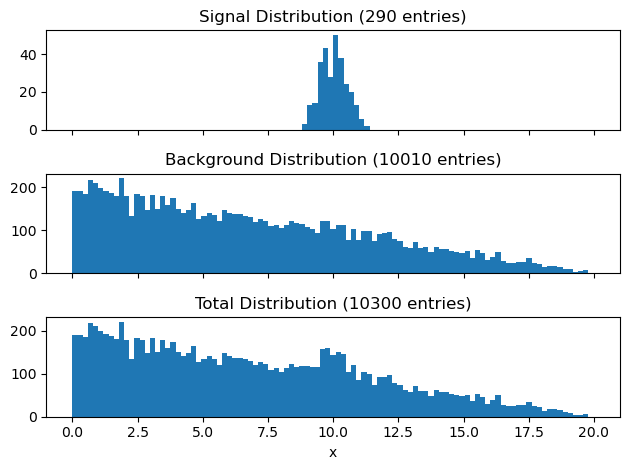

In [10]:
run_q1()

**Question 2**

In [11]:
def run_q2():
    # Define parameters for gaussian
    mean = 10000.
    measurement = 10000.+300.
    sigma = np.sqrt(mean)
    low_limit = mean - 1000.
    high_limit = mean + 1000.
    interval_limits = (measurement, high_limit)

    # Define the gaussian pdf
    pdf = Gaussian(mean, sigma, low_limit, high_limit)

    p_val, n_sigma = find_sig(pdf, interval_limits)

    print('A flutuation of %s events from a mean of %s has a significance of %.3f\u03C3 and a p-value of %s.' % (int(measurement), int(mean), n_sigma, p_val))

In [12]:
run_q2()

A flutuation of 10300 events from a mean of 10000 has a significance of 3.205σ and a p-value of 0.0013498980316301113.


**Question 3**

In [13]:
def run_q3():
    # Define parameters for the bkg pdf
    slope = -1.
    intercept = 20.
    low_limit_lin = 0.
    high_limit_lin = 20.
    low_limit_possible_sig = 5.
    high_limit_possible_sig = 15.

    # Define parameters for the gaussian here
    mean = 0.5*10000. 
    sigma = np.sqrt(mean)           # This is using Poisson to Gaus distribution approximation
    low_lim_gaus = mean - 500.
    high_lim_gaus = mean + 500.
    measurement = 0.5*10000. + 300.
    interval_lim = (measurement, high_lim_gaus)         # The integral limits for k>=10300

    # Now, define a linear and a Gaussian pdf
    pdf_bkg = Linear(slope, intercept, low_limit_lin, high_limit_lin)
    pdf_gaus = Gaussian(mean, sigma, low_lim_gaus, high_lim_gaus)

    # Compute the bkg integrals
    tot_bkg_integral = pdf_bkg.integrate(low_limit_lin, high_limit_lin)
    possible_sig_integral = pdf_bkg.integrate(low_limit_possible_sig, high_limit_possible_sig)

    bkg_evt_ratio = possible_sig_integral/tot_bkg_integral

    print('The ratio between expected background events between the ranges (%s, %s) and (%s, %s) was found by using integration, with a value of %.2f%%' % \
          (low_limit_lin, high_limit_lin,low_limit_possible_sig, high_limit_possible_sig, bkg_evt_ratio*100))

    # Compute significance of having 300 additional events for a background with a 50% in expected background events.
    p_val, n_sigma = find_sig(pdf_gaus, interval_lim)

    print('A flutuation of %s events from a mean of %s has a significance of %.3f\u03C3 and p-value of %s' % (int(measurement), int(mean), n_sigma, p_val) )

In [14]:
run_q3()

The ratio between expected background events between the ranges (0.0, 20.0) and (5.0, 15.0) was found by using integration, with a value of 50.00%
A flutuation of 5300 events from a mean of 5000 has a significance of 4.396σ and p-value of 1.1045247730579902e-05


The reasoning behind the increase in the significance between question 2 and 3 arose from the fact that by applying the limits of (5,15), the selection only tosses out events generated by the background distribution, while all the events generated from the signal distribution are kept. This results in events generated by the background distribution making up a smaller proportion from the overall total number of events in the distribution. 

Proportionality of background events in respective intervals are: 

(0,20): $\frac{10000}{10300} = 97.1$%

(5,15): $\frac{5000}{5300} = 94.3$%

From the above, with a gaussian distribution of events for a linear background, the distance between the point and mean is "further" for the point at 5300 and for the mean at 5000, comparing to the distance between the point and the mean with the point at 10300 and the mean at 10000.

**Question 4**

In [15]:
def run_q4():
    # Define parameters for the toy dataset generation
    slope = -1.
    intercept = 20.
    sigma = 0.5
    mean = 10.
    low_lim = 0.
    high_lim = 20.
    n_event_sig = 150
    n_event_bkg = 10000
    tot_expected_evts = n_event_sig + n_event_bkg
    signalFraction = n_event_sig/tot_expected_evts

    # generate signalWithBackground obj
    pdf = single_toy(intercept, slope, sigma, mean, low_lim, high_lim, n_event_sig, plotDistribution=False)
    obs_data = pdf.mass

    # Construct hypothesis obj
    null_hypo = SignalWithBackground(intercept, slope, sigma=1e-10, mean=1e-10, signalFraction=0., loBound=low_lim, highBound=high_lim)
    alt_hypo = SignalWithBackground(intercept, slope, sigma, mean, low_lim, high_lim, signalFraction)
    
    # Now initialize minimization statistic obj
    null_stat = ChiSquaredLogLike(null_hypo, obs_data)
    alt_stat = ChiSquaredLogLike(alt_hypo, obs_data)
    
    # initialize minuit obj
    minuit_null = Minuit(null_stat.evalNull, slope=-0.8, intercept=16.)
    minuit_alt = Minuit(alt_stat.evalAlt, signalFraction=0.5, slope=-0.8, intercept=16.)

    # Set reasonable limts for the parameters
    minuit_null.limits = [(-1.5, -0.1), (15., 20.)]
    minuit_alt.limits = [(0, 1), (-1.5, -0.1), (15., 20.)]

    # Minimize Hypotheses
    result_null = minuit_null.migrad()
    result_alt = minuit_alt.migrad()
    print('H_0: ChiSq = %.5f' % (result_null.fval))
    print('H_1: ChiSq = %.5f' % (result_alt.fval))

    # compute the difference in ChiSq using Wilk's theorem
    ChiSq_diff = result_null.fval - result_alt.fval
    print('Wilk\'s Theorem: delta_chiSq = %.5f' % (ChiSq_diff))

    # Now, find p-val and significance of the deviation between the two hypotheses
    p_val = chi2.cdf(ChiSq_diff, df=1)
    n_sigma = np.sqrt(2)*erfinv(1-p_val)
    print('The significance of there being a deviation between the two hypothesis is calculate and is %.2f\u03C3 and the p-value is %.3f' \
          % (n_sigma, p_val))
    
    # plot hypothesis
    mass = np.linspace(low_lim, high_lim, 1000)
    plt.hist(obs_data, bins=100, density=True, color='paleturquoise', label='Data Distribution')
    plt.plot(mass, null_hypo.evaluate(mass)/null_hypo.integrate(low_lim, high_lim), linestyle='--', color='blue',\
             label='$H_0$ Null Hypothesis')
    plt.plot(mass, alt_hypo.evaluate(mass)/alt_hypo.integrate(low_lim, high_lim), linestyle=':', color='red',\
             label='$H_1$ Alternative Hypothesis')
    plt.title('Observed Data with fitted Hypotheses')
    plt.xlabel('Mass (GeV)')
    plt.ylabel('Probability')
    plt.legend()
    plt.savefig('plots/obs_data_w_fitted_hypo.png', dpi=600)
    plt.show()


H_0: ChiSq = 0.06914
H_1: ChiSq = 0.05705
Wilk's Theorem: delta_chiSq = 0.01209
The significance of there being a deviation between the two hypothesis is calculate and is 1.71σ and the p-value is 0.088


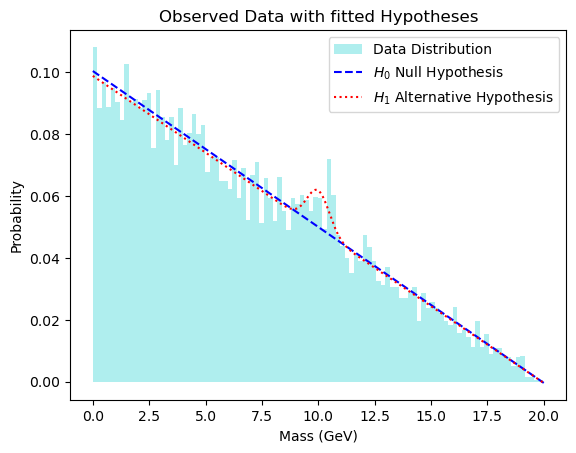

In [16]:
run_q4()

**Question 5**

In [17]:
def run_q5():
    # Define parameters for the toy dataset generation
    slope = -1.
    intercept = 20.
    sigma = 0.5
    mean = 10.
    low_lim = 0.
    high_lim = 20.
    n_evt_sig = 0
    n_evt_bkg = 10000
    nbins = 100

    # create an empty list for holding delta_chiSq values
    delta_chiSq_val_list = []
    # iterate to calculate the chiSq difference using Wilk's theorem 1000 times for linear distribution
    for i in range(1000):
        delta_chisq_val = chiSq_diff(intercept, slope, sigma, mean, low_lim, high_lim, n_evt_sig, n_evt_bkg, nbins)
        delta_chiSq_val_list.append(delta_chisq_val)
        # Print out progress of loop every 100 epochs
        if (i+1) % 100 == 0:
            print('Progress: %s/1000' % (i+1))
    
    # convert list to array
    delta_chiSq_val_array = np.array(delta_chiSq_val_list)

    plt.close("all")
    # now, plot delta chiSq distribution
    weights = np.ones_like(delta_chiSq_val_array)/delta_chiSq_val_array.size
    fig, axes = plt.subplots(2, 1)
    axes[0].hist(delta_chiSq_val_array, bins=50, weights=weights, color="paleturquoise", range=(0., 0.001))
    axes[0].set_ylabel("Probability")
    axes[0].set_xlabel(r"$\Delta\chi^2$")
    axes[0].set_title(r"$\Delta\chi^2$ Probability Density Function")
    axes[1].hist(delta_chiSq_val_array, bins=nbins, density=True, color="paleturquoise", cumulative=True, range=(0., 0.001))
    axes[1].set_ylabel("Probability")
    axes[1].set_title(r'$\Delta\chi^2$ Cumulative Density Function')
    axes[1].set_xlabel(r"Cumulative $\Delta\chi^2$")
    fig.tight_layout()
    plt.show()
    

Progress: 100/1000
Progress: 200/1000
Progress: 300/1000
Progress: 400/1000
Progress: 500/1000
Progress: 600/1000
Progress: 700/1000
Progress: 800/1000
Progress: 900/1000
Progress: 1000/1000


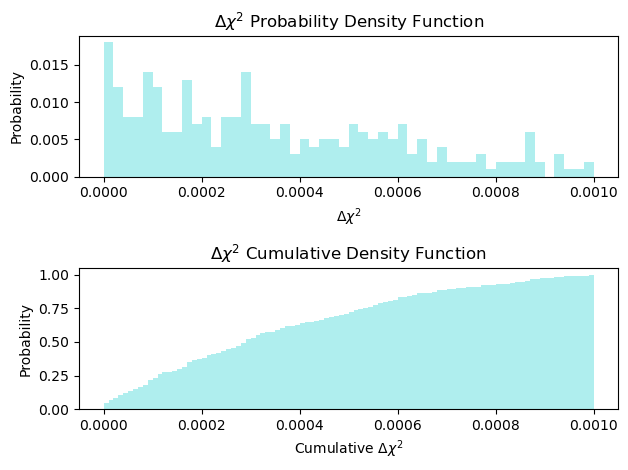

In [18]:
run_q5()